# Выпускной проект: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми   электродами. Они установлены в крышке ковша.   
  
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).  
  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
1. data_arc_new.csv — данные об электродах;
2. data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
3. data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
4. data_gas_new.csv — данные о продувке сплава газом;
5. data_temp_new.csv — результаты измерения температуры;
6. data_wire_new.csv — данные о проволочных материалах (объём);
7. data_wire_time_new.csv — данные о проволочных материалах (время).

### План работы

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

## Загрузка данных

### Изучим датафрейм с данными об электродах

In [2]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')

In [3]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Из первичного осмотра можем сказать, что пропусков нет, однако на этапе предобработки нужно будет поменять тип данных у столбцов с датами.

In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Очевидно что минимально значение в стобце реактивная мощность - выброс и придется избавиться от него на этапе предобработки.

### Изучим датафрейм с данными о подаче сыпучих материалов (объём)

In [6]:
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

In [7]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [8]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропусков очень много, однако эти пропуски могут говорить о том, что конкретный сыпучий материал не использовался.

### Изучим датафрейм с данными о подаче сыпучих материалов (время)

In [10]:
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [11]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [12]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Видим, что ситуация с пропусками тут такая же, как и в предыдущем датафрейме, что подтверждает наш довод. А также даты нужно привести к правильному типу данных.

### Изучим датафрейм с данными о продувке сплава газом

In [13]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [14]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [15]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Переименнуем столбец Газ 1 в нормальный вид.

In [16]:
data_gas.columns = ['key', 'gas_1']

In [17]:
data_gas['gas_1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

С данными в этом датафрейме все в порядке.

### Изучим датафрейм с результатами измерения температуры

In [18]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [19]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [20]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [21]:
data_temp['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

Видим пропущенные значения в столбце с температурой, а так же неправильный тип данных у столбца с датой.

### Изучим датафрейм с данными о проволочных материалах (объём)

In [22]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')

In [23]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [25]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Здесь все обстоит так же как и с данными о подаче сыпучих материалов.

### Изучим датафрейм с данными о проволочных материалах (время)

In [26]:
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [27]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


## Исследовательский анализ и предобработка данных

### Предобработка data_arc

Начнем с датафрейма data_arc. Избавимся от аномального значения, переведем даты в нужный тип и приведем названия столбцов к нормальному виду. 

In [29]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

Узнаем партию с аномалией, чтобы удалить всю партию.

In [30]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_time,end_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [31]:
data_arc = data_arc.query('key != 2116')

In [32]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'])
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'])

In [33]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   start_time      14872 non-null  datetime64[ns]
 2   end_time        14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


### data_bulk и data_bulk_time

Для начала еще раз вглянем на кол-во пропущенных в data_bulk

In [34]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Значений в некоторых столбцах очень мало(меньше 10% от общего кол-ва), а это плохо скажется на обучении модели. Поэтому предлагается удалить такие столбцы, а именно Bulk 1, 2, 5, 7, 8, 9, 10, 11, 13

In [35]:
columns_to_drop = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']

for i in data_bulk.columns:
    if i in columns_to_drop:
        data_bulk = data_bulk.drop(i, axis=1)

In [36]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 3   1298 non-null   float64
 2   Bulk 4   1014 non-null   float64
 3   Bulk 6   576 non-null    float64
 4   Bulk 12  2450 non-null   float64
 5   Bulk 14  2806 non-null   float64
 6   Bulk 15  2248 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 171.2 KB


Так же заменим все пропущенные значения на 0

In [37]:
data_bulk = data_bulk.fillna(0)

Удалим данные по этим материал так же и из таблицы data_bulk_time, а так же приведем даты к правильному формату.

In [38]:
for i in data_bulk_time.columns:
    if i in columns_to_drop:
        data_bulk_time = data_bulk_time.drop(i, axis=1)

In [39]:
for i in data_bulk_time.columns:
    if i != 'key':
        data_bulk_time[i] = pd.to_datetime(data_bulk_time[i])

In [40]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 3   1298 non-null   datetime64[ns]
 2   Bulk 4   1014 non-null   datetime64[ns]
 3   Bulk 6   576 non-null    datetime64[ns]
 4   Bulk 12  2450 non-null   datetime64[ns]
 5   Bulk 14  2806 non-null   datetime64[ns]
 6   Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](6), int64(1)
memory usage: 171.2 KB


### Займемся датафреймом с целевым признаком data_temp

Приведем назания стобцов к правильному виду, а так же дату к правильному типу. И сформируем датафрейм с начальной и конечной температурой, а так же нас интересуют только те key, где есть хотя бы 2 измерения температуры.

In [41]:
data_temp.columns = ['key', 'time', 'temp']

In [42]:
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [43]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Для каждого ключа найдем время первого и последнего замера температуры.

In [44]:
date_temp_time = pd.pivot_table(data_temp, values='time', index='key', aggfunc={'time': [np.min, np.max]})

In [45]:
date_temp_time.head()

,amax,amin
key,,
1,2019-05-03 11:30:38,2019-05-03 11:02:04
2,2019-05-03 11:55:09,2019-05-03 11:34:04
3,2019-05-03 12:35:57,2019-05-03 12:06:44
4,2019-05-03 12:59:47,2019-05-03 12:39:27
5,2019-05-03 13:36:39,2019-05-03 13:11:03


In [46]:
date_temp_time['heat_time'] = date_temp_time['amax'] - date_temp_time['amin']

Теперь на основе этого датафрейма создадим датафрейм с температурой первого и последнего замера.

In [47]:
first = list(date_temp_time['amin'])
last = list(date_temp_time['amax'])

In [48]:
first_temp = data_temp.query('time in @first')

In [49]:
first_temp

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
6,2,2019-05-03 11:34:04,1581.0
11,3,2019-05-03 12:06:44,1596.0
17,4,2019-05-03 12:39:27,1601.0
22,5,2019-05-03 13:11:03,1576.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


In [50]:
last_temp = data_temp.query('time in @last')

In [51]:
last_temp

,key,time,temp
5,1,2019-05-03 11:30:38,1613.0
10,2,2019-05-03 11:55:09,1602.0
16,3,2019-05-03 12:35:57,1599.0
21,4,2019-05-03 12:59:47,1625.0
26,5,2019-05-03 13:36:39,1602.0
...,...,...,...
18066,3237,2019-09-06 11:55:45,NaN
18070,3238,2019-09-06 12:34:37,NaN
18079,3239,2019-09-06 15:09:55,NaN
18085,3240,2019-09-06 16:35:26,NaN


In [52]:
first_temp = first_temp.set_index('key')
last_temp = last_temp.set_index('key')

In [53]:
data_temp_new = first_temp.copy()
data_temp_new.columns = ['time', 'first_temp']

In [54]:
data_temp_new = data_temp_new.drop('time', axis=1)

In [55]:
data_temp_new['last_temp'] = last_temp['temp']

In [56]:
#data_temp_new['heat_time'] = date_temp_time['heat_time']

In [57]:
#data_temp_new['heat_time'] =  pd.to_numeric(data_temp_new['heat_time'])

Избавимся от пропусков.

In [58]:
data_temp_new = data_temp_new.dropna()

In [59]:
data_temp_new

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


### data_wire и data_wire_time

In [60]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Поступим так же, как и с data_bulk, а именно избавимся от Wire 3, 4, 5, 6, 7, 8, 9.

In [61]:
columns_to_drop = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

for i in data_wire.columns:
    if i in columns_to_drop:
        data_wire = data_wire.drop(i, axis=1)

In [62]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


In [63]:
data_wire = data_wire.fillna(0)

In [64]:
for i in data_wire_time.columns:
    if i in columns_to_drop:
        data_wire_time = data_wire_time.drop(i, axis=1)

In [65]:
for i in data_wire_time.columns:
    if i != 'key':
        data_wire_time[i] = pd.to_datetime(data_wire_time[i])

In [66]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 72.3 KB


## Объединение данных

### Добавим в data_arc полную мощность

Добавим в датафрейм data_arc столбец с полной мощностью

In [67]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**.5

In [68]:
data_arc.head()

,key,start_time,end_time,active_power,reactive_power,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


In [69]:
data_arc['heat_time'] = data_arc['end_time'] - data_arc['start_time']

In [70]:
data_arc['heat_time'] =  data_arc['heat_time'].dt.total_seconds()

In [71]:
data_arc.head()

,key,start_time,end_time,active_power,reactive_power,full_power,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


In [72]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   start_time      14872 non-null  datetime64[ns]
 2   end_time        14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
 5   full_power      14872 non-null  float64       
 6   heat_time       14872 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 929.5 KB


Теперь сгруппируем по ключу и посчитаем суммы мощностей.

In [73]:
data_arc_powers = pd.pivot_table(data_arc, values=['active_power', 'reactive_power', 'full_power', 'heat_time'],
                                 index='key', aggfunc={sum})
data_arc_powers.columns = ['active_power_sum', 'reactive_power_sum', 'full_power_sum', 'heat_time_sum']

In [74]:
data_arc_powers.head()

,active_power_sum,reactive_power_sum,full_power_sum,heat_time_sum
key,,,,
1,3.036730,3.718736,1098.0,2.142821
2,2.139408,2.588349,811.0,1.453357
3,4.063641,5.019223,655.0,2.937457
4,2.706489,3.400038,741.0,2.056992
5,2.252950,2.816980,869.0,1.687991


### Начнем объединение

Для начала сделаем 'key' индексами всех наших датафреймов, которые мы будем объдинять

In [75]:
data_bulk = data_bulk.set_index('key')
data_wire = data_wire.set_index('key')
data_gas = data_gas.set_index('key')

In [76]:
data = pd.concat([data_temp_new, data_bulk, data_wire, data_gas, data_arc_powers], axis=1)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2477 non-null   float64
 1   last_temp           2477 non-null   float64
 2   Bulk 3              3129 non-null   float64
 3   Bulk 4              3129 non-null   float64
 4   Bulk 6              3129 non-null   float64
 5   Bulk 12             3129 non-null   float64
 6   Bulk 14             3129 non-null   float64
 7   Bulk 15             3129 non-null   float64
 8   Wire 1              3081 non-null   float64
 9   Wire 2              3081 non-null   float64
 10  gas_1               3239 non-null   float64
 11  active_power_sum    3213 non-null   float64
 12  reactive_power_sum  3213 non-null   float64
 13  full_power_sum      3213 non-null   float64
 14  heat_time_sum       3213 non-null   float64
dtypes: float64(15)
memory usage: 405.1 KB


## Исследовательский анализ и предобработка данных объединённого датафрейма

Удалим строки, где нет данных о температуре, так как это наш целевой признак. А так же заполним все пропуски нулями.

In [78]:
data = data.dropna(subset=['last_temp'])

In [79]:
data = data.dropna()

In [80]:
data.head()

,first_temp,last_temp,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas_1,active_power_sum,reactive_power_sum,full_power_sum,heat_time_sum
key,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,3.036730,3.718736,1098.0,2.142821
2,1581.0,1602.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,2.139408,2.588349,811.0,1.453357
3,1596.0,1599.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,4.063641,5.019223,655.0,2.937457
4,1601.0,1625.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,2.706489,3.400038,741.0,2.056992
5,1576.0,1602.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,2.252950,2.816980,869.0,1.687991


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2328 non-null   float64
 1   last_temp           2328 non-null   float64
 2   Bulk 3              2328 non-null   float64
 3   Bulk 4              2328 non-null   float64
 4   Bulk 6              2328 non-null   float64
 5   Bulk 12             2328 non-null   float64
 6   Bulk 14             2328 non-null   float64
 7   Bulk 15             2328 non-null   float64
 8   Wire 1              2328 non-null   float64
 9   Wire 2              2328 non-null   float64
 10  gas_1               2328 non-null   float64
 11  active_power_sum    2328 non-null   float64
 12  reactive_power_sum  2328 non-null   float64
 13  full_power_sum      2328 non-null   float64
 14  heat_time_sum       2328 non-null   float64
dtypes: float64(15)
memory usage: 291.0 KB


In [82]:
data.corr()

,first_temp,last_temp,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas_1,active_power_sum,reactive_power_sum,full_power_sum,heat_time_sum
first_temp,1.000000,0.252389,-0.104478,0.144715,-0.096800,-0.058673,-0.130971,-0.040533,0.209392,-0.086157,0.037345,-0.119865,-0.120336,-0.305299,-0.120518
last_temp,0.252389,1.000000,-0.036365,0.187687,-0.180843,0.266851,0.114991,0.265801,0.317362,-0.207076,0.059203,0.176871,0.175218,0.278112,0.171462
Bulk 3,-0.104478,-0.036365,1.000000,-0.295654,0.065904,0.018021,0.010920,-0.013250,0.039475,0.095595,0.059641,0.103007,0.102412,0.092347,0.100739
Bulk 4,0.144715,0.187687,-0.295654,1.000000,-0.251250,0.105477,-0.090467,0.101180,0.297471,-0.268325,0.017589,0.005297,0.004980,-0.028640,0.004410
Bulk 6,-0.096800,-0.180843,0.065904,-0.251250,1.000000,-0.111874,0.177184,-0.108210,-0.235474,0.205287,0.139723,0.133920,0.133768,0.163067,0.133034
Bulk 12,-0.058673,0.266851,0.018021,0.105477,-0.111874,1.000000,0.482063,0.614169,0.169889,-0.098605,0.217433,0.285683,0.286050,0.466359,0.285379
Bulk 14,-0.130971,0.114991,0.010920,-0.090467,0.177184,0.482063,1.000000,0.265816,-0.053698,0.036436,0.268898,0.300354,0.299385,0.461740,0.296199
Bulk 15,-0.040533,0.265801,-0.013250,0.101180,-0.108210,0.614169,0.265816,1.000000,0.118117,-0.096781,0.043662,0.169358,0.169039,0.295245,0.167678
Wire 1,0.209392,0.317362,0.039475,0.297471,-0.235474,0.169889,-0.053698,0.118117,1.000000,-0.068451,0.117331,0.137700,0.138132,0.055142,0.138165
Wire 2,-0.086157,-0.207076,0.095595,-0.268325,0.205287,-0.098605,0.036436,-0.096781,-0.068451,1.000000,0.104261,0.062259,0.062173,0.054251,0.061666


Видим сильную корелляцию между мощностями, поэтому будет уместно оставить только одну из них, оставим full_power_sum.

Спасибо за совет, принято!

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

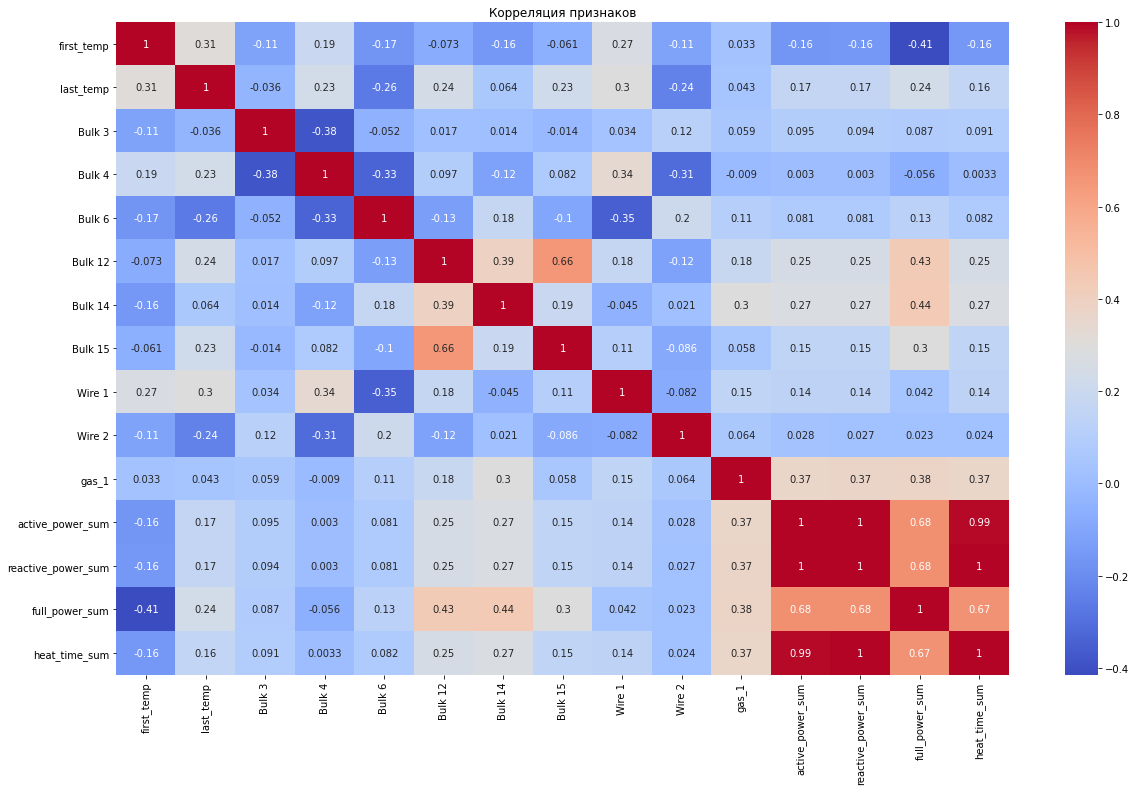

In [84]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [85]:
data = data.drop(['active_power_sum', 'reactive_power_sum'], axis=1)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2328 non-null   float64
 1   last_temp       2328 non-null   float64
 2   Bulk 3          2328 non-null   float64
 3   Bulk 4          2328 non-null   float64
 4   Bulk 6          2328 non-null   float64
 5   Bulk 12         2328 non-null   float64
 6   Bulk 14         2328 non-null   float64
 7   Bulk 15         2328 non-null   float64
 8   Wire 1          2328 non-null   float64
 9   Wire 2          2328 non-null   float64
 10  gas_1           2328 non-null   float64
 11  full_power_sum  2328 non-null   float64
 12  heat_time_sum   2328 non-null   float64
dtypes: float64(13)
memory usage: 254.6 KB


In [87]:
data.corr()['last_temp']

first_temp        0.252389
last_temp         1.000000
Bulk 3           -0.036365
Bulk 4            0.187687
Bulk 6           -0.180843
Bulk 12           0.266851
Bulk 14           0.114991
Bulk 15           0.265801
Wire 1            0.317362
Wire 2           -0.207076
gas_1             0.059203
full_power_sum    0.278112
heat_time_sum     0.171462
Name: last_temp, dtype: float64

## Подготовка данных

Разобьем данные на обучающую и тестовую выборки.

In [88]:
features = data.drop('last_temp', axis=1)
target = data['last_temp']

In [89]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=281223)

In [90]:
features_train.shape

(1746, 12)

In [91]:
len(target_train)

1746

In [92]:
features_test.shape

(582, 12)

In [93]:
len(target_test)

582

Маштабируем признаки с помощью StandardScaler

In [94]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
features_test = pd.DataFrame(scaler.transform(features_test))


## Обучение моделей машинного обучения

### Начнем с модели линейной регрессии

In [95]:
model_lin = LinearRegression()
m_l = GridSearchCV(estimator=model_lin, param_grid={}, scoring='neg_mean_absolute_error', cv=5, verbose=3)
m_l.fit(features_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................................................ total time=   0.0s
[CV 2/5] END ................................................ total time=   0.0s
[CV 3/5] END ................................................ total time=   0.0s
[CV 4/5] END ................................................ total time=   0.0s
[CV 5/5] END ................................................ total time=   0.0s


GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring='neg_mean_absolute_error', verbose=3)

In [96]:
m_l.best_score_

-6.727712223971766

Получили MAE равное 6.727712223971766

### Теперь обучим случайный лес

In [97]:
model_forest = RandomForestRegressor(random_state=281223)
params_forest = {'max_depth': range(5, 10), 'n_estimators': range(50, 351, 50)}
m_f = GridSearchCV(estimator=model_forest, param_grid=params_forest, scoring='neg_mean_absolute_error', cv=2)
m_f.fit(features_train, target_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=281223),
             param_grid={'max_depth': range(5, 10),
                         'n_estimators': range(50, 351, 50)},
             scoring='neg_mean_absolute_error')

In [98]:
m_f.best_estimator_

RandomForestRegressor(max_depth=9, n_estimators=350, random_state=281223)

In [99]:
m_f.best_score_

-6.421022494465365

Для случайного леса получили MAE 6.421022494465365

### CatBoost

In [100]:
model_cat = CatBoostRegressor()
params_cat = {'loss_function': ["MAE"], 'verbose': [False], 'random_state': [281223], 'max_depth': range(1, 5),
          'n_estimators': range(100, 501, 100)}
m_cat = GridSearchCV(estimator=model_cat, param_grid=params_cat, scoring='neg_mean_absolute_error', cv=5)
m_cat.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0d7293cee0>,
             param_grid={'loss_function': ['MAE'], 'max_depth': range(1, 5),
                         'n_estimators': range(100, 501, 100),
                         'random_state': [281223], 'verbose': [False]},
             scoring='neg_mean_absolute_error')

In [101]:
m_cat.best_score_

-6.09730319046421

In [109]:
m_cat.best_params_

{'loss_function': 'MAE',
 'max_depth': 3,
 'n_estimators': 500,
 'random_state': 281223,
 'verbose': False}

Для CatBoost получили MAE 6.09730319046421

## Выбор лучшей модели

Теперь проверим лучшую модель на тестовой выборке

In [104]:
predictions_cat = m_cat.predict(features_test)
mean_absolute_error(target_test, predictions_cat)

6.403953325945593

Получили на тестовой выборке значние MAE 6.403953325945593

## Отчет

Ответы на вопросы:  
  1. Какие пункты плана были выполнены, а какие — нет (поясните, почему)? Все запланированные пункты были мною выполнены.
  2. Какие трудности возникли и как вы их преодалели? Не получалось достигнуть нужную метрику, однако добавив новый признак время нагрева ковша все получилось.
  3. Какие ключевые шаги в решении задачи выделили? Анализ, предобработка, создание моделей.
  
Список признаков, используемых для обучения лучшей модели
и описание их предобработки.  
first_temp, Bulk 3, Bulk 4, Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2, gas_1, full_power_sum, heat_time_sum
  
Лучшая модель CatBoostRegressor c параметрами  
{'loss_function': 'MAE',
 'max_depth': 3,
 'n_estimators': 500,
 'random_state': 281223,
 'verbose': False}